In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'comp411/assignments/assignment1/'
FOLDERNAME = None
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/comp411/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from comp411.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from comp411.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'comp411/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your own interest.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from comp411.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [10]:
# Use the validation set to tune the learning rate and regularization strength

from comp411.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.42 on the validation set.       #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
for rate in learning_rates:
    for reg in regularization_strengths:
        svm = LinearSVM()
        svm.train(X_train_feats, y_train, rate, reg)
        pred = svm.predict(X_val_feats)
        acc = float(np.sum(pred == y_val)) / y_val.shape[0] 
        if acc > best_val:
            best_val = acc
            best_svm = svm

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

best validation accuracy achieved during cross-validation: 0.361000


In [11]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.366


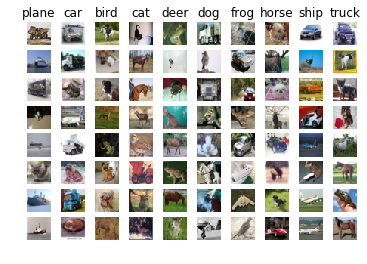

In [12]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:



$\color{blue}{\textit Your Answer:}$ They make sense, because looking this missclassification errors, we can understand whether our model is good enough or not.


## Neural Network on image features
Earlier in this assigment we saw that training a four-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 58% classification accuracy.

In [13]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [28]:
from comp411.classifiers.fc_net import FourLayerNet
from comp411.solver import Solver

input_dim = X_train_feats.shape[1]
hidden_dim = 200
num_classes = 10

data = {
    'X_train': X_train_feats, 
    'y_train': y_train, 
    'X_val': X_val_feats, 
    'y_val': y_val, 
    'X_test': X_test_feats, 
    'y_test': y_test, 
}

net = FourLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a four-layer neural network on image features. You may want to  #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
for rate in learning_rates:
      for reg in regularization_strengths:
            solver = Solver(net, data)
            solver.train()


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


(Iteration 1 / 4900) loss: 2.302575
(Epoch 0 / 10) train acc: 0.094000; val_acc: 0.081000
(Iteration 11 / 4900) loss: 2.302503
(Iteration 21 / 4900) loss: 2.302655
(Iteration 31 / 4900) loss: 2.302462
(Iteration 41 / 4900) loss: 2.302634
(Iteration 51 / 4900) loss: 2.302390
(Iteration 61 / 4900) loss: 2.302570
(Iteration 71 / 4900) loss: 2.302674
(Iteration 81 / 4900) loss: 2.302440
(Iteration 91 / 4900) loss: 2.302759
(Iteration 101 / 4900) loss: 2.302638
(Iteration 111 / 4900) loss: 2.302679
(Iteration 121 / 4900) loss: 2.302117
(Iteration 131 / 4900) loss: 2.302405
(Iteration 141 / 4900) loss: 2.302714
(Iteration 151 / 4900) loss: 2.303045
(Iteration 161 / 4900) loss: 2.302823
(Iteration 171 / 4900) loss: 2.302930
(Iteration 181 / 4900) loss: 2.302378
(Iteration 191 / 4900) loss: 2.302419
(Iteration 201 / 4900) loss: 2.302863
(Iteration 211 / 4900) loss: 2.302935
(Iteration 221 / 4900) loss: 2.302802
(Iteration 231 / 4900) loss: 2.302685
(Iteration 241 / 4900) loss: 2.302959
(Iterat

(Iteration 2101 / 4900) loss: 2.302997
(Iteration 2111 / 4900) loss: 2.301814
(Iteration 2121 / 4900) loss: 2.302697
(Iteration 2131 / 4900) loss: 2.301800
(Iteration 2141 / 4900) loss: 2.303571
(Iteration 2151 / 4900) loss: 2.302253
(Iteration 2161 / 4900) loss: 2.302332
(Iteration 2171 / 4900) loss: 2.301662
(Iteration 2181 / 4900) loss: 2.302831
(Iteration 2191 / 4900) loss: 2.303158
(Iteration 2201 / 4900) loss: 2.302450
(Iteration 2211 / 4900) loss: 2.302684
(Iteration 2221 / 4900) loss: 2.302823
(Iteration 2231 / 4900) loss: 2.302507
(Iteration 2241 / 4900) loss: 2.301459
(Iteration 2251 / 4900) loss: 2.301696
(Iteration 2261 / 4900) loss: 2.302407
(Iteration 2271 / 4900) loss: 2.302323
(Iteration 2281 / 4900) loss: 2.303333
(Iteration 2291 / 4900) loss: 2.302633
(Iteration 2301 / 4900) loss: 2.302205
(Iteration 2311 / 4900) loss: 2.303250
(Iteration 2321 / 4900) loss: 2.300349
(Iteration 2331 / 4900) loss: 2.302355
(Iteration 2341 / 4900) loss: 2.302804
(Iteration 2351 / 4900) l

(Iteration 4171 / 4900) loss: 2.303703
(Iteration 4181 / 4900) loss: 2.302633
(Iteration 4191 / 4900) loss: 2.301992
(Iteration 4201 / 4900) loss: 2.301802
(Iteration 4211 / 4900) loss: 2.302392
(Iteration 4221 / 4900) loss: 2.302379
(Iteration 4231 / 4900) loss: 2.302743
(Iteration 4241 / 4900) loss: 2.303294
(Iteration 4251 / 4900) loss: 2.301892
(Iteration 4261 / 4900) loss: 2.303725
(Iteration 4271 / 4900) loss: 2.302616
(Iteration 4281 / 4900) loss: 2.301442
(Iteration 4291 / 4900) loss: 2.302380
(Iteration 4301 / 4900) loss: 2.302887
(Iteration 4311 / 4900) loss: 2.303198
(Iteration 4321 / 4900) loss: 2.303225
(Iteration 4331 / 4900) loss: 2.303350
(Iteration 4341 / 4900) loss: 2.302946
(Iteration 4351 / 4900) loss: 2.303047
(Iteration 4361 / 4900) loss: 2.302847
(Iteration 4371 / 4900) loss: 2.302187
(Iteration 4381 / 4900) loss: 2.302270
(Iteration 4391 / 4900) loss: 2.302735
(Iteration 4401 / 4900) loss: 2.302732
(Epoch 9 / 10) train acc: 0.101000; val_acc: 0.113000
(Iteration

(Iteration 1331 / 4900) loss: 2.302635
(Iteration 1341 / 4900) loss: 2.301755
(Iteration 1351 / 4900) loss: 2.302681
(Iteration 1361 / 4900) loss: 2.302633
(Iteration 1371 / 4900) loss: 2.303076
(Iteration 1381 / 4900) loss: 2.301639
(Iteration 1391 / 4900) loss: 2.301701
(Iteration 1401 / 4900) loss: 2.303427
(Iteration 1411 / 4900) loss: 2.302426
(Iteration 1421 / 4900) loss: 2.302773
(Iteration 1431 / 4900) loss: 2.301289
(Iteration 1441 / 4900) loss: 2.303366
(Iteration 1451 / 4900) loss: 2.302569
(Iteration 1461 / 4900) loss: 2.303089
(Epoch 3 / 10) train acc: 0.100000; val_acc: 0.098000
(Iteration 1471 / 4900) loss: 2.302352
(Iteration 1481 / 4900) loss: 2.301796
(Iteration 1491 / 4900) loss: 2.302104
(Iteration 1501 / 4900) loss: 2.302198
(Iteration 1511 / 4900) loss: 2.302064
(Iteration 1521 / 4900) loss: 2.302239
(Iteration 1531 / 4900) loss: 2.303186
(Iteration 1541 / 4900) loss: 2.302366
(Iteration 1551 / 4900) loss: 2.303124
(Iteration 1561 / 4900) loss: 2.303031
(Iteration

(Iteration 3401 / 4900) loss: 2.301901
(Iteration 3411 / 4900) loss: 2.302924
(Iteration 3421 / 4900) loss: 2.302530
(Epoch 7 / 10) train acc: 0.092000; val_acc: 0.078000
(Iteration 3431 / 4900) loss: 2.302638
(Iteration 3441 / 4900) loss: 2.301478
(Iteration 3451 / 4900) loss: 2.302483
(Iteration 3461 / 4900) loss: 2.302722
(Iteration 3471 / 4900) loss: 2.301738
(Iteration 3481 / 4900) loss: 2.301278
(Iteration 3491 / 4900) loss: 2.301684
(Iteration 3501 / 4900) loss: 2.301725
(Iteration 3511 / 4900) loss: 2.302094
(Iteration 3521 / 4900) loss: 2.302878
(Iteration 3531 / 4900) loss: 2.301295
(Iteration 3541 / 4900) loss: 2.302280
(Iteration 3551 / 4900) loss: 2.302109
(Iteration 3561 / 4900) loss: 2.302962
(Iteration 3571 / 4900) loss: 2.302240
(Iteration 3581 / 4900) loss: 2.302603
(Iteration 3591 / 4900) loss: 2.303225
(Iteration 3601 / 4900) loss: 2.302306
(Iteration 3611 / 4900) loss: 2.302431
(Iteration 3621 / 4900) loss: 2.303413
(Iteration 3631 / 4900) loss: 2.301901
(Iteration

(Iteration 541 / 4900) loss: 2.301494
(Iteration 551 / 4900) loss: 2.302454
(Iteration 561 / 4900) loss: 2.302697
(Iteration 571 / 4900) loss: 2.301702
(Iteration 581 / 4900) loss: 2.303803
(Iteration 591 / 4900) loss: 2.303294
(Iteration 601 / 4900) loss: 2.302535
(Iteration 611 / 4900) loss: 2.302146
(Iteration 621 / 4900) loss: 2.303045
(Iteration 631 / 4900) loss: 2.303549
(Iteration 641 / 4900) loss: 2.301870
(Iteration 651 / 4900) loss: 2.302708
(Iteration 661 / 4900) loss: 2.301860
(Iteration 671 / 4900) loss: 2.301751
(Iteration 681 / 4900) loss: 2.302418
(Iteration 691 / 4900) loss: 2.301760
(Iteration 701 / 4900) loss: 2.302210
(Iteration 711 / 4900) loss: 2.301688
(Iteration 721 / 4900) loss: 2.302628
(Iteration 731 / 4900) loss: 2.303049
(Iteration 741 / 4900) loss: 2.303105
(Iteration 751 / 4900) loss: 2.301771
(Iteration 761 / 4900) loss: 2.301679
(Iteration 771 / 4900) loss: 2.302119
(Iteration 781 / 4900) loss: 2.302561
(Iteration 791 / 4900) loss: 2.302138
(Iteration 8

(Iteration 2601 / 4900) loss: 2.302484
(Iteration 2611 / 4900) loss: 2.302729
(Iteration 2621 / 4900) loss: 2.301391
(Iteration 2631 / 4900) loss: 2.302354
(Iteration 2641 / 4900) loss: 2.302442
(Iteration 2651 / 4900) loss: 2.301751
(Iteration 2661 / 4900) loss: 2.302870
(Iteration 2671 / 4900) loss: 2.301642
(Iteration 2681 / 4900) loss: 2.301171
(Iteration 2691 / 4900) loss: 2.301691
(Iteration 2701 / 4900) loss: 2.301118
(Iteration 2711 / 4900) loss: 2.301922
(Iteration 2721 / 4900) loss: 2.302332
(Iteration 2731 / 4900) loss: 2.302175
(Iteration 2741 / 4900) loss: 2.303107
(Iteration 2751 / 4900) loss: 2.302375
(Iteration 2761 / 4900) loss: 2.301152
(Iteration 2771 / 4900) loss: 2.303443
(Iteration 2781 / 4900) loss: 2.302336
(Iteration 2791 / 4900) loss: 2.303336
(Iteration 2801 / 4900) loss: 2.301179
(Iteration 2811 / 4900) loss: 2.302448
(Iteration 2821 / 4900) loss: 2.301548
(Iteration 2831 / 4900) loss: 2.301270
(Iteration 2841 / 4900) loss: 2.301150
(Iteration 2851 / 4900) l

(Iteration 4681 / 4900) loss: 2.301056
(Iteration 4691 / 4900) loss: 2.300752
(Iteration 4701 / 4900) loss: 2.302255
(Iteration 4711 / 4900) loss: 2.302875
(Iteration 4721 / 4900) loss: 2.300890
(Iteration 4731 / 4900) loss: 2.300736
(Iteration 4741 / 4900) loss: 2.302004
(Iteration 4751 / 4900) loss: 2.301933
(Iteration 4761 / 4900) loss: 2.302090
(Iteration 4771 / 4900) loss: 2.301804
(Iteration 4781 / 4900) loss: 2.300747
(Iteration 4791 / 4900) loss: 2.302327
(Iteration 4801 / 4900) loss: 2.302387
(Iteration 4811 / 4900) loss: 2.302084
(Iteration 4821 / 4900) loss: 2.300997
(Iteration 4831 / 4900) loss: 2.301184
(Iteration 4841 / 4900) loss: 2.302756
(Iteration 4851 / 4900) loss: 2.301616
(Iteration 4861 / 4900) loss: 2.303106
(Iteration 4871 / 4900) loss: 2.301318
(Iteration 4881 / 4900) loss: 2.302493
(Iteration 4891 / 4900) loss: 2.303424
(Epoch 10 / 10) train acc: 0.102000; val_acc: 0.098000
(Iteration 1 / 4900) loss: 2.303837
(Epoch 0 / 10) train acc: 0.161000; val_acc: 0.1510

(Iteration 1881 / 4900) loss: 2.301946
(Iteration 1891 / 4900) loss: 2.301443
(Iteration 1901 / 4900) loss: 2.303971
(Iteration 1911 / 4900) loss: 2.302894
(Iteration 1921 / 4900) loss: 2.301997
(Iteration 1931 / 4900) loss: 2.301670
(Iteration 1941 / 4900) loss: 2.301808
(Iteration 1951 / 4900) loss: 2.302102
(Epoch 4 / 10) train acc: 0.097000; val_acc: 0.119000
(Iteration 1961 / 4900) loss: 2.303245
(Iteration 1971 / 4900) loss: 2.300531
(Iteration 1981 / 4900) loss: 2.302074
(Iteration 1991 / 4900) loss: 2.302556
(Iteration 2001 / 4900) loss: 2.301443
(Iteration 2011 / 4900) loss: 2.301771
(Iteration 2021 / 4900) loss: 2.303033
(Iteration 2031 / 4900) loss: 2.302407
(Iteration 2041 / 4900) loss: 2.301876
(Iteration 2051 / 4900) loss: 2.302652
(Iteration 2061 / 4900) loss: 2.304358
(Iteration 2071 / 4900) loss: 2.301693
(Iteration 2081 / 4900) loss: 2.302209
(Iteration 2091 / 4900) loss: 2.302170
(Iteration 2101 / 4900) loss: 2.303342
(Iteration 2111 / 4900) loss: 2.301755
(Iteration

(Iteration 3981 / 4900) loss: 2.301231
(Iteration 3991 / 4900) loss: 2.302087
(Iteration 4001 / 4900) loss: 2.301841
(Iteration 4011 / 4900) loss: 2.301523
(Iteration 4021 / 4900) loss: 2.302622
(Iteration 4031 / 4900) loss: 2.301737
(Iteration 4041 / 4900) loss: 2.302271
(Iteration 4051 / 4900) loss: 2.302445
(Iteration 4061 / 4900) loss: 2.301154
(Iteration 4071 / 4900) loss: 2.301896
(Iteration 4081 / 4900) loss: 2.301009
(Iteration 4091 / 4900) loss: 2.301524
(Iteration 4101 / 4900) loss: 2.302575
(Iteration 4111 / 4900) loss: 2.301065
(Iteration 4121 / 4900) loss: 2.301237
(Iteration 4131 / 4900) loss: 2.301914
(Iteration 4141 / 4900) loss: 2.301918
(Iteration 4151 / 4900) loss: 2.301530
(Iteration 4161 / 4900) loss: 2.302631
(Iteration 4171 / 4900) loss: 2.301549
(Iteration 4181 / 4900) loss: 2.301598
(Iteration 4191 / 4900) loss: 2.302070
(Iteration 4201 / 4900) loss: 2.301559
(Iteration 4211 / 4900) loss: 2.302418
(Iteration 4221 / 4900) loss: 2.301220
(Iteration 4231 / 4900) l

(Iteration 1171 / 4900) loss: 2.302190
(Iteration 1181 / 4900) loss: 2.301655
(Iteration 1191 / 4900) loss: 2.302131
(Iteration 1201 / 4900) loss: 2.301782
(Iteration 1211 / 4900) loss: 2.301383
(Iteration 1221 / 4900) loss: 2.301680
(Iteration 1231 / 4900) loss: 2.301869
(Iteration 1241 / 4900) loss: 2.301493
(Iteration 1251 / 4900) loss: 2.301335
(Iteration 1261 / 4900) loss: 2.301199
(Iteration 1271 / 4900) loss: 2.301020
(Iteration 1281 / 4900) loss: 2.301699
(Iteration 1291 / 4900) loss: 2.300694
(Iteration 1301 / 4900) loss: 2.302711
(Iteration 1311 / 4900) loss: 2.301749
(Iteration 1321 / 4900) loss: 2.301793
(Iteration 1331 / 4900) loss: 2.301429
(Iteration 1341 / 4900) loss: 2.302118
(Iteration 1351 / 4900) loss: 2.301049
(Iteration 1361 / 4900) loss: 2.301613
(Iteration 1371 / 4900) loss: 2.301095
(Iteration 1381 / 4900) loss: 2.302004
(Iteration 1391 / 4900) loss: 2.301035
(Iteration 1401 / 4900) loss: 2.302492
(Iteration 1411 / 4900) loss: 2.302542
(Iteration 1421 / 4900) l

(Iteration 3231 / 4900) loss: 2.298000
(Iteration 3241 / 4900) loss: 2.298398
(Iteration 3251 / 4900) loss: 2.298141
(Iteration 3261 / 4900) loss: 2.300505
(Iteration 3271 / 4900) loss: 2.297539
(Iteration 3281 / 4900) loss: 2.298096
(Iteration 3291 / 4900) loss: 2.298196
(Iteration 3301 / 4900) loss: 2.298239
(Iteration 3311 / 4900) loss: 2.297357
(Iteration 3321 / 4900) loss: 2.297218
(Iteration 3331 / 4900) loss: 2.297255
(Iteration 3341 / 4900) loss: 2.297135
(Iteration 3351 / 4900) loss: 2.296628
(Iteration 3361 / 4900) loss: 2.296577
(Iteration 3371 / 4900) loss: 2.296320
(Iteration 3381 / 4900) loss: 2.297834
(Iteration 3391 / 4900) loss: 2.297426
(Iteration 3401 / 4900) loss: 2.298016
(Iteration 3411 / 4900) loss: 2.296559
(Iteration 3421 / 4900) loss: 2.297505
(Epoch 7 / 10) train acc: 0.165000; val_acc: 0.171000
(Iteration 3431 / 4900) loss: 2.296421
(Iteration 3441 / 4900) loss: 2.297146
(Iteration 3451 / 4900) loss: 2.297626
(Iteration 3461 / 4900) loss: 2.297773
(Iteration

(Iteration 421 / 4900) loss: 2.300435
(Iteration 431 / 4900) loss: 2.300200
(Iteration 441 / 4900) loss: 2.299920
(Iteration 451 / 4900) loss: 2.300350
(Iteration 461 / 4900) loss: 2.299871
(Iteration 471 / 4900) loss: 2.299318
(Iteration 481 / 4900) loss: 2.300474
(Epoch 1 / 10) train acc: 0.168000; val_acc: 0.187000
(Iteration 491 / 4900) loss: 2.301021
(Iteration 501 / 4900) loss: 2.300102
(Iteration 511 / 4900) loss: 2.300235
(Iteration 521 / 4900) loss: 2.300821
(Iteration 531 / 4900) loss: 2.301546
(Iteration 541 / 4900) loss: 2.299767
(Iteration 551 / 4900) loss: 2.299833
(Iteration 561 / 4900) loss: 2.299463
(Iteration 571 / 4900) loss: 2.300633
(Iteration 581 / 4900) loss: 2.298915
(Iteration 591 / 4900) loss: 2.301226
(Iteration 601 / 4900) loss: 2.300971
(Iteration 611 / 4900) loss: 2.300933
(Iteration 621 / 4900) loss: 2.300488
(Iteration 631 / 4900) loss: 2.299759
(Iteration 641 / 4900) loss: 2.300529
(Iteration 651 / 4900) loss: 2.299989
(Iteration 661 / 4900) loss: 2.298

(Iteration 2511 / 4900) loss: 2.269012
(Iteration 2521 / 4900) loss: 2.268506
(Iteration 2531 / 4900) loss: 2.268465
(Iteration 2541 / 4900) loss: 2.262021
(Iteration 2551 / 4900) loss: 2.233551
(Iteration 2561 / 4900) loss: 2.259437
(Iteration 2571 / 4900) loss: 2.257912
(Iteration 2581 / 4900) loss: 2.253826
(Iteration 2591 / 4900) loss: 2.255714
(Iteration 2601 / 4900) loss: 2.255974
(Iteration 2611 / 4900) loss: 2.244258
(Iteration 2621 / 4900) loss: 2.233301
(Iteration 2631 / 4900) loss: 2.241659
(Iteration 2641 / 4900) loss: 2.234055
(Iteration 2651 / 4900) loss: 2.243831
(Iteration 2661 / 4900) loss: 2.247888
(Iteration 2671 / 4900) loss: 2.229985
(Iteration 2681 / 4900) loss: 2.234782
(Iteration 2691 / 4900) loss: 2.231662
(Iteration 2701 / 4900) loss: 2.244236
(Iteration 2711 / 4900) loss: 2.224736
(Iteration 2721 / 4900) loss: 2.212465
(Iteration 2731 / 4900) loss: 2.230171
(Iteration 2741 / 4900) loss: 2.218231
(Iteration 2751 / 4900) loss: 2.220869
(Iteration 2761 / 4900) l

(Iteration 4591 / 4900) loss: 1.839027
(Iteration 4601 / 4900) loss: 1.884108
(Iteration 4611 / 4900) loss: 1.825667
(Iteration 4621 / 4900) loss: 1.841944
(Iteration 4631 / 4900) loss: 1.849967
(Iteration 4641 / 4900) loss: 1.896828
(Iteration 4651 / 4900) loss: 1.817231
(Iteration 4661 / 4900) loss: 1.920395
(Iteration 4671 / 4900) loss: 1.822215
(Iteration 4681 / 4900) loss: 1.991112
(Iteration 4691 / 4900) loss: 1.829924
(Iteration 4701 / 4900) loss: 1.859065
(Iteration 4711 / 4900) loss: 1.872382
(Iteration 4721 / 4900) loss: 1.912600
(Iteration 4731 / 4900) loss: 1.828860
(Iteration 4741 / 4900) loss: 1.878651
(Iteration 4751 / 4900) loss: 1.806714
(Iteration 4761 / 4900) loss: 1.921618
(Iteration 4771 / 4900) loss: 1.930740
(Iteration 4781 / 4900) loss: 1.898345
(Iteration 4791 / 4900) loss: 1.824378
(Iteration 4801 / 4900) loss: 1.955901
(Iteration 4811 / 4900) loss: 1.978022
(Iteration 4821 / 4900) loss: 1.987488
(Iteration 4831 / 4900) loss: 1.919031
(Iteration 4841 / 4900) l

(Iteration 1771 / 4900) loss: 1.615716
(Iteration 1781 / 4900) loss: 1.787239
(Iteration 1791 / 4900) loss: 1.633368
(Iteration 1801 / 4900) loss: 1.541159
(Iteration 1811 / 4900) loss: 1.553145
(Iteration 1821 / 4900) loss: 1.693730
(Iteration 1831 / 4900) loss: 1.739679
(Iteration 1841 / 4900) loss: 1.662674
(Iteration 1851 / 4900) loss: 1.614554
(Iteration 1861 / 4900) loss: 1.628043
(Iteration 1871 / 4900) loss: 1.676523
(Iteration 1881 / 4900) loss: 1.679354
(Iteration 1891 / 4900) loss: 1.750021
(Iteration 1901 / 4900) loss: 1.787463
(Iteration 1911 / 4900) loss: 1.729621
(Iteration 1921 / 4900) loss: 1.757751
(Iteration 1931 / 4900) loss: 1.692599
(Iteration 1941 / 4900) loss: 1.718204
(Iteration 1951 / 4900) loss: 1.664986
(Epoch 4 / 10) train acc: 0.337000; val_acc: 0.336000
(Iteration 1961 / 4900) loss: 1.604462
(Iteration 1971 / 4900) loss: 1.594956
(Iteration 1981 / 4900) loss: 1.757433
(Iteration 1991 / 4900) loss: 1.528114
(Iteration 2001 / 4900) loss: 1.630955
(Iteration

(Iteration 3851 / 4900) loss: 1.623054
(Iteration 3861 / 4900) loss: 1.622686
(Iteration 3871 / 4900) loss: 1.680248
(Iteration 3881 / 4900) loss: 1.622346
(Iteration 3891 / 4900) loss: 1.420631
(Iteration 3901 / 4900) loss: 1.606533
(Iteration 3911 / 4900) loss: 1.595972
(Epoch 8 / 10) train acc: 0.416000; val_acc: 0.392000
(Iteration 3921 / 4900) loss: 1.536791
(Iteration 3931 / 4900) loss: 1.565467
(Iteration 3941 / 4900) loss: 1.556896
(Iteration 3951 / 4900) loss: 1.467469
(Iteration 3961 / 4900) loss: 1.463702
(Iteration 3971 / 4900) loss: 1.565187
(Iteration 3981 / 4900) loss: 1.488711
(Iteration 3991 / 4900) loss: 1.675717
(Iteration 4001 / 4900) loss: 1.482041
(Iteration 4011 / 4900) loss: 1.670504
(Iteration 4021 / 4900) loss: 1.657194
(Iteration 4031 / 4900) loss: 1.674568
(Iteration 4041 / 4900) loss: 1.649708
(Iteration 4051 / 4900) loss: 1.377831
(Iteration 4061 / 4900) loss: 1.586885
(Iteration 4071 / 4900) loss: 1.625033
(Iteration 4081 / 4900) loss: 1.428778
(Iteration

(Iteration 1031 / 4900) loss: 1.455618
(Iteration 1041 / 4900) loss: 1.638197
(Iteration 1051 / 4900) loss: 1.491983
(Iteration 1061 / 4900) loss: 1.408112
(Iteration 1071 / 4900) loss: 1.493587
(Iteration 1081 / 4900) loss: 1.443199
(Iteration 1091 / 4900) loss: 1.568805
(Iteration 1101 / 4900) loss: 1.459870
(Iteration 1111 / 4900) loss: 1.280678
(Iteration 1121 / 4900) loss: 1.538878
(Iteration 1131 / 4900) loss: 1.625158
(Iteration 1141 / 4900) loss: 1.455519
(Iteration 1151 / 4900) loss: 1.564651
(Iteration 1161 / 4900) loss: 1.478183
(Iteration 1171 / 4900) loss: 1.671423
(Iteration 1181 / 4900) loss: 1.484214
(Iteration 1191 / 4900) loss: 1.530471
(Iteration 1201 / 4900) loss: 1.561479
(Iteration 1211 / 4900) loss: 1.465351
(Iteration 1221 / 4900) loss: 1.268014
(Iteration 1231 / 4900) loss: 1.477126
(Iteration 1241 / 4900) loss: 1.482682
(Iteration 1251 / 4900) loss: 1.416245
(Iteration 1261 / 4900) loss: 1.705698
(Iteration 1271 / 4900) loss: 1.416176
(Iteration 1281 / 4900) l

(Iteration 3091 / 4900) loss: 1.339656
(Iteration 3101 / 4900) loss: 1.377723
(Iteration 3111 / 4900) loss: 1.428209
(Iteration 3121 / 4900) loss: 1.204936
(Iteration 3131 / 4900) loss: 1.374217
(Iteration 3141 / 4900) loss: 1.239665
(Iteration 3151 / 4900) loss: 1.477643
(Iteration 3161 / 4900) loss: 1.260543
(Iteration 3171 / 4900) loss: 1.374819
(Iteration 3181 / 4900) loss: 1.365287
(Iteration 3191 / 4900) loss: 1.530445
(Iteration 3201 / 4900) loss: 1.294757
(Iteration 3211 / 4900) loss: 1.554054
(Iteration 3221 / 4900) loss: 1.313691
(Iteration 3231 / 4900) loss: 1.286709
(Iteration 3241 / 4900) loss: 1.325220
(Iteration 3251 / 4900) loss: 1.479259
(Iteration 3261 / 4900) loss: 1.341849
(Iteration 3271 / 4900) loss: 1.369564
(Iteration 3281 / 4900) loss: 1.454826
(Iteration 3291 / 4900) loss: 1.478374
(Iteration 3301 / 4900) loss: 1.215807
(Iteration 3311 / 4900) loss: 1.380059
(Iteration 3321 / 4900) loss: 1.215714
(Iteration 3331 / 4900) loss: 1.297609
(Iteration 3341 / 4900) l

(Iteration 281 / 4900) loss: 1.333429
(Iteration 291 / 4900) loss: 1.402948
(Iteration 301 / 4900) loss: 1.190261
(Iteration 311 / 4900) loss: 1.192663
(Iteration 321 / 4900) loss: 1.278176
(Iteration 331 / 4900) loss: 1.420125
(Iteration 341 / 4900) loss: 1.387523
(Iteration 351 / 4900) loss: 1.161668
(Iteration 361 / 4900) loss: 1.303519
(Iteration 371 / 4900) loss: 1.188086
(Iteration 381 / 4900) loss: 1.215223
(Iteration 391 / 4900) loss: 1.179487
(Iteration 401 / 4900) loss: 1.138521
(Iteration 411 / 4900) loss: 1.240945
(Iteration 421 / 4900) loss: 1.320979
(Iteration 431 / 4900) loss: 1.213332
(Iteration 441 / 4900) loss: 1.301689
(Iteration 451 / 4900) loss: 1.308976
(Iteration 461 / 4900) loss: 1.154604
(Iteration 471 / 4900) loss: 1.233001
(Iteration 481 / 4900) loss: 1.127544
(Epoch 1 / 10) train acc: 0.519000; val_acc: 0.482000
(Iteration 491 / 4900) loss: 1.356185
(Iteration 501 / 4900) loss: 1.230167
(Iteration 511 / 4900) loss: 1.359026
(Iteration 521 / 4900) loss: 1.387

(Iteration 2371 / 4900) loss: 1.203518
(Iteration 2381 / 4900) loss: 1.397917
(Iteration 2391 / 4900) loss: 1.012807
(Iteration 2401 / 4900) loss: 1.388078
(Iteration 2411 / 4900) loss: 1.208296
(Iteration 2421 / 4900) loss: 1.214170
(Iteration 2431 / 4900) loss: 1.234932
(Iteration 2441 / 4900) loss: 1.431480
(Epoch 5 / 10) train acc: 0.559000; val_acc: 0.503000
(Iteration 2451 / 4900) loss: 1.145556
(Iteration 2461 / 4900) loss: 1.012245
(Iteration 2471 / 4900) loss: 1.306354
(Iteration 2481 / 4900) loss: 1.255578
(Iteration 2491 / 4900) loss: 1.237003
(Iteration 2501 / 4900) loss: 0.973248
(Iteration 2511 / 4900) loss: 1.118622
(Iteration 2521 / 4900) loss: 1.155065
(Iteration 2531 / 4900) loss: 1.162814
(Iteration 2541 / 4900) loss: 1.212725
(Iteration 2551 / 4900) loss: 1.266857
(Iteration 2561 / 4900) loss: 1.364672
(Iteration 2571 / 4900) loss: 1.205991
(Iteration 2581 / 4900) loss: 1.388748
(Iteration 2591 / 4900) loss: 1.048267
(Iteration 2601 / 4900) loss: 1.140657
(Iteration

(Iteration 4441 / 4900) loss: 1.115176
(Iteration 4451 / 4900) loss: 1.321654
(Iteration 4461 / 4900) loss: 1.288167
(Iteration 4471 / 4900) loss: 1.157587
(Iteration 4481 / 4900) loss: 1.026933
(Iteration 4491 / 4900) loss: 1.251052
(Iteration 4501 / 4900) loss: 1.067464
(Iteration 4511 / 4900) loss: 1.150085
(Iteration 4521 / 4900) loss: 1.346590
(Iteration 4531 / 4900) loss: 1.229699
(Iteration 4541 / 4900) loss: 1.139339
(Iteration 4551 / 4900) loss: 1.151762
(Iteration 4561 / 4900) loss: 1.133232
(Iteration 4571 / 4900) loss: 1.145280
(Iteration 4581 / 4900) loss: 1.063359
(Iteration 4591 / 4900) loss: 1.035530
(Iteration 4601 / 4900) loss: 1.206337
(Iteration 4611 / 4900) loss: 1.120547
(Iteration 4621 / 4900) loss: 1.239348
(Iteration 4631 / 4900) loss: 1.221384
(Iteration 4641 / 4900) loss: 1.259823
(Iteration 4651 / 4900) loss: 1.245223
(Iteration 4661 / 4900) loss: 1.217865
(Iteration 4671 / 4900) loss: 1.132063
(Iteration 4681 / 4900) loss: 1.143859
(Iteration 4691 / 4900) l

In [31]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.
best_net=net
y_test_pred = np.argmax(best_net.loss(data['X_test']), axis=1)
test_acc = (y_test_pred == data['y_test']).mean()
print(test_acc)

0.523
